# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load
from glob import glob

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable
images='./Flickr8K/Images'

all_imgs = glob(images + '/*.jpg')
print("The total images present in the dataset: {}".format(len(all_imgs)))

text_file='./Flickr8K/captions.txt'
all_text=pd.read_csv(text_file)
print("The total Captions present in the dataset: {}".format(len(all_text)))

The total images present in the dataset: 8091
The total Captions present in the dataset: 40455


### Visualise both the images & text present in the dataset

In [3]:
all_imgs[:6]

['./Flickr8K/Images/2201222219_8d656b0633.jpg',
 './Flickr8K/Images/3681172959_6674c118d2.jpg',
 './Flickr8K/Images/3257107194_f235c8f7ab.jpg',
 './Flickr8K/Images/2831656774_36982aafdb.jpg',
 './Flickr8K/Images/3718892835_a3e74a3417.jpg',
 './Flickr8K/Images/3360930596_1e75164ce6.jpg']

In [4]:
all_text.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


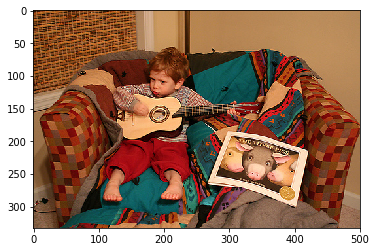

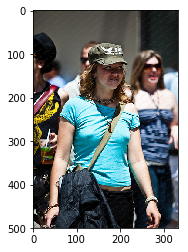

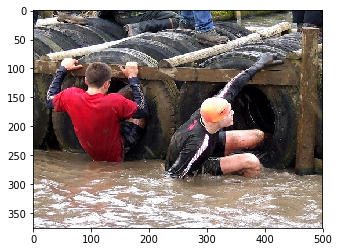

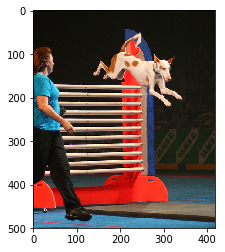

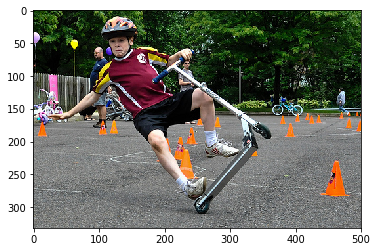

In [5]:
import matplotlib.pyplot as plt
for i in range(5):
    plt.figure()
    img = Image.open(all_imgs[i])
    plt.imshow(img)

In [6]:
#Import the dataset and read the text file into a seperate variable
def load_doc(filename):
    
    #your code here
    text= pd.read_csv(filename)
    return text

doc = load_doc(text_file)
doc[:10]

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [7]:
all_img_id= all_text['image'] #store all the image id here
all_img_vector= './Flickr8K/Images/'+all_text['image'] #store all the image path here
annotations= all_text['caption'] #store all the captions here

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,./Flickr8K/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [8]:
#Create the vocabulary & the counter for the captions
from collections import Counter
vocabulary = []
for txt in df.Captions.values:
    vocabulary.extend(txt.split())

val_count=Counter(vocabulary)
val_count

Counter({'A': 22667,
         'child': 1477,
         'in': 18962,
         'a': 40319,
         'pink': 734,
         'dress': 348,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1945,
         'entry': 1,
         'way': 50,
         '.': 36577,
         'girl': 3218,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 510,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7984,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 772,
         'on': 10730,
         'road': 388,
         'white': 3876,
         'brown': 2475,
         'spots': 29,
         'staring'

In [9]:
vocabulary[:5]

['A', 'child', 'in', 'a', 'pink']

In [10]:
len(val_count)

9630

In [11]:
#Visualise the top 30 occuring words in the captions
from operator import itemgetter
sorted(val_count.items(), key=itemgetter(1),reverse=True)[:30]

[('a', 40319),
 ('.', 36577),
 ('A', 22667),
 ('in', 18962),
 ('the', 15328),
 ('on', 10730),
 ('is', 9345),
 ('and', 8850),
 ('dog', 7984),
 ('with', 7760),
 ('man', 6829),
 ('of', 6712),
 ('Two', 4365),
 ('white', 3876),
 ('black', 3696),
 ('are', 3503),
 ('boy', 3442),
 (',', 3232),
 ('woman', 3228),
 ('girl', 3218),
 ('to', 3173),
 ('The', 3089),
 ('wearing', 3061),
 ('at', 2904),
 ('water', 2778),
 ('red', 2660),
 ('brown', 2475),
 ('people', 2446),
 ('young', 2432),
 ('his', 2357)]

In [12]:
#Create a list which contains all the captions
annotations=annotations

#add the <start> & <end> token to all those captions as well
for i in range(len(annotations)):
    annotations[i]='<start> '+annotations[i]+' <end>'
    
#Create a list which contains all the path to the images
all_img_path=all_img_vector.tolist()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [13]:
# Reducing Data size
def data_limiter(num,annotations,all_img_path):
    annotations, all_img_path = shuffle(annotations,all_img_path,random_state=1)
    all_img_path = all_img_path[:num]
    annotations = annotations[:num]
    return annotations,all_img_path

annotations,all_img_path = data_limiter(20000,annotations,all_img_path)
len(annotations),len(all_img_path)

(20000, 20000)

In [14]:
annotations[:5]

4012     <start> Several children leaping into a pile o...
23715    <start> A man hiking in the wilderness giving ...
17297    <start> A white dog is running through the wat...
15209    <start> a young man relaxing his legs on a pic...
37982    <start> a man in a yellow cap is on the beach ...
Name: caption, dtype: object

In [15]:
all_img_path[:5]

['./Flickr8K/Images/1956678973_223cb1b847.jpg',
 './Flickr8K/Images/3256603992_67312b5a36.jpg',
 './Flickr8K/Images/2938747424_64e64784f0.jpg',
 './Flickr8K/Images/2831314869_5025300133.jpg',
 './Flickr8K/Images/516725192_c9cdd63878.jpg']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [16]:
# create the tokenizer
import tensorflow as tf
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)

In [17]:
# Create word-to-index and index-to-word mappings.
train_seqs = tokenizer.texts_to_sequences(annotations)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
tokenizer.index_word[5]

'in'

In [19]:
tokenizer.word_index['in']

5

In [20]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
from operator import itemgetter
sorted(tokenizer.word_docs.items(), key=itemgetter(1),reverse=True)[:30]

[('<end>', 20000),
 ('<start>', 20000),
 ('a', 16486),
 ('in', 8271),
 ('the', 7199),
 ('on', 4997),
 ('is', 4439),
 ('and', 4018),
 ('dog', 3662),
 ('with', 3662),
 ('man', 3512),
 ('of', 3084),
 ('two', 2755),
 ('black', 1880),
 ('white', 1821),
 ('are', 1731),
 ('boy', 1681),
 ('woman', 1669),
 ('girl', 1621),
 ('wearing', 1531),
 ('to', 1505),
 ('people', 1429),
 ('at', 1420),
 ('water', 1380),
 ('young', 1296),
 ('red', 1284),
 ('brown', 1271),
 ('an', 1171),
 ('his', 1131),
 ('blue', 1074)]

In [21]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(20000, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [22]:
#write your code here
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [23]:
#Split image and caption into Train & Validation set
img_name_train, img_name_val, cap_train, cap_val = train_test_split(all_img_path,cap_vector, test_size=0.2, random_state=42)
len(img_name_train),len(cap_train),len(img_name_val),len(cap_val)

(16000, 16000, 4000, 4000)

In [24]:
#Load Image
encode_train = sorted(set(all_img_path)) # Get unique images
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [25]:
sample_img_batch, sample_cap_batch = next(iter(image_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 299, 299, 3)
(64,)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [26]:
# Load the preprocessed image
encode_train = sorted(set(all_img_path)) # Get unique images
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [27]:
#Initializing InceptionV3 and loading the pretrained Imagenet weights
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

In [28]:
%%time
# Caching the features extracted from InceptionV3
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

### Combining image & Caption &  Creating train & test dataset

In [29]:
# Map func to load cached numpy files and returning image tensor & captions
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [30]:
# Parameters
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [31]:
#----------------------------- Train Dataset ----------------------------------
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel(image & caption)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [32]:
#------------------------------ Test Dataset ----------------------------------
test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

#Shuffle & Batch
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [33]:
# Each Image shape & Caption Shape check
sample_img_batch, sample_cap_batch = next(iter(dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [34]:
embedding_dim = 256 
units = 512
vocab_size = top_k+ 1 #top 5,000 words +1
train_num_steps =len(img_name_train) // BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(img_name_val) // BATCH_SIZE #len(total test images) // BATCH_SIZE

### Encoder

In [35]:
class Encoder(tf.keras.Model):
    # This encoder passes the features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(Encoder, self).__init__()
        # shape after fc == (batch_size, 49, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

    def call(self, x):
        #x= self.dropout(x)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x   

In [36]:
encoder=Encoder(embedding_dim)

### Attention & Decoder

In [38]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                      return_sequences=True,
                                      return_state=True,
                                      recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)

    def call(self, x, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x= self.dropout(x)
        x= self.batchnormalization(x)
        x = self.fc2(x)
        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [39]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [40]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [41]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

In [42]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [43]:
checkpoint_path_ckpt = "./Checkpoints/Train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [45]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [46]:
test_loss_plot = []

@tf.function
def test_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        # passing the features through the decoder
        predictions, hidden,attention_weights = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    
    return loss, total_loss

In [47]:
for epoch in range(start_epoch,10):
    start = time.time()
    #For Train
    #==========================================================
    total_loss_train = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss_train += t_loss
    #Stroring the epoch and loss value to plot later
    loss_plot.append(total_loss_train/train_num_steps)
    
    #For Test
    #==========================================================
    total_loss_test = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
    #Stroring the epoch and loss value to plot later
    test_loss_plot.append(total_loss_test/test_num_steps)
    if epoch % 5 ==0:
        ckpt_manager.save()
        
    print('Epoch {} TrainLoss {:.6f} TestLoss {:.6f} '.format(epoch+1,(total_loss_train/train_num_steps),(total_loss_test/test_num_steps)))
    print('Time taken for 1 epoch {} sec\n'.format(time.time()-start))
    

Epoch 3 TrainLoss 1.602447 TestLoss 1.349819 
Time taken for 1 epoch 717.1043512821198 sec

Epoch 4 TrainLoss 1.240035 TestLoss 1.207855 
Time taken for 1 epoch 616.5495409965515 sec

Epoch 5 TrainLoss 1.113586 TestLoss 1.151551 
Time taken for 1 epoch 621.5132877826691 sec

Epoch 6 TrainLoss 1.030787 TestLoss 1.124997 
Time taken for 1 epoch 617.8302013874054 sec

Epoch 7 TrainLoss 0.963452 TestLoss 1.117830 
Time taken for 1 epoch 620.7188441753387 sec

Epoch 8 TrainLoss 0.905278 TestLoss 1.123919 
Time taken for 1 epoch 618.8867137432098 sec

Epoch 9 TrainLoss 0.850663 TestLoss 1.127803 
Time taken for 1 epoch 622.0057623386383 sec

Epoch 10 TrainLoss 0.799246 TestLoss 1.141572 
Time taken for 1 epoch 619.5446116924286 sec



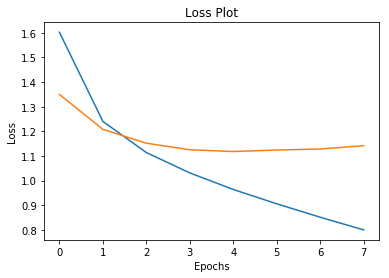

In [48]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [49]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [50]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

35

In [51]:
attention_features_shape=64

In [52]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [54]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [55]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a white dog swims with a stick <end>
Prediction Caption: the white dog runs in the blue water with a stick in the water <end>


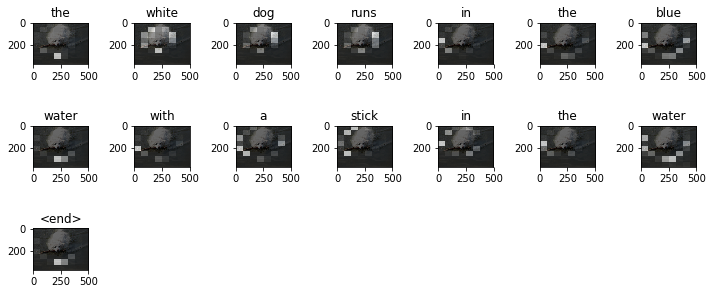

In [56]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# Evaluating on Unseen Image

In [159]:
from nltk.translate.bleu_score import sentence_bleu

Prediction Caption: an surfer on a wave <end>


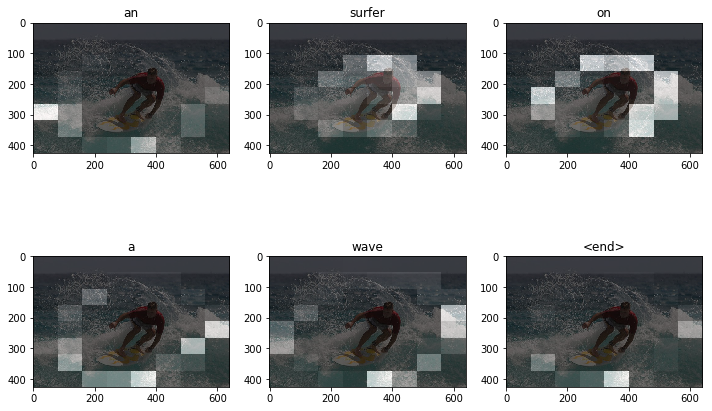

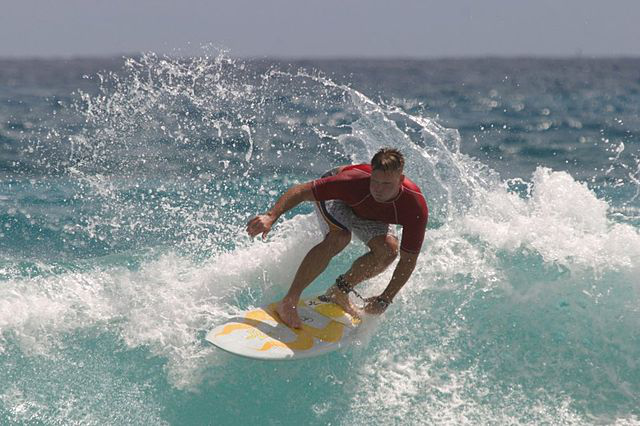

In [64]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)


In [58]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

BELU score: 23.618327637050733
Real Caption: a man wearing a gray coat looks to the right on a snowy street
Prediction Caption: a man stands in a winter crowded street


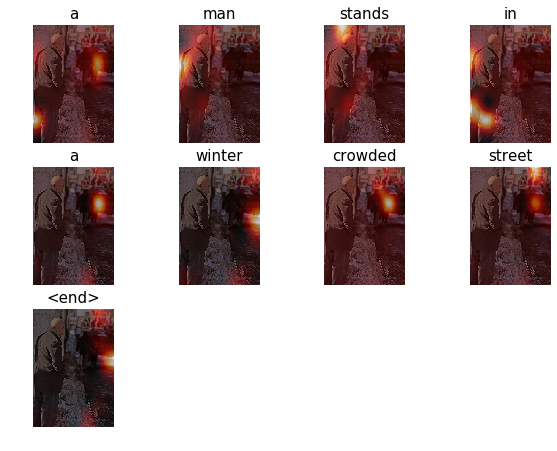

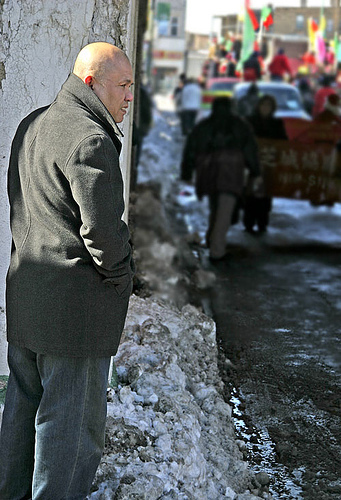

In [76]:
rid = np.random.randint(0, len(img_name_val))
test_image = img_name_val[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=(1,0,0,0)) #set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)